In [1]:
%pylab inline

from sigvisa import Sigvisa
import numpy as np
s = Sigvisa()

from sigvisa.signals.io import fetch_waveform_ims, fetch_waveform_sac


Populating the interactive namespace from numpy and matplotlib


# Comparing IDCX/vDEC with SAC/LLNL data

In [27]:
# missing starts at 1203732962

h = 23
vdec_s = fetch_waveform_ims("NV01", "sz", 1203646562 + h * 3600, 1203646562+ (h+1)*3600) 
llnl_s = fetch_waveform_sac("NV01", "sz", 1203646562+ h * 3600, 1203646562+(h+1)*3600) 

In [28]:
print vdec_s
print llnl_s

wave pts 145600 @ 40 Hz. time: Sat, 23 Feb 2008 01:15:42 (1203729342.0). 
sta: NV01, chan SHZ. filter_str: , fraction_valid: 0.989010989011, npts: 145600, srate: 40.0, valid_len: 3600.0
wave pts 145600 @ 40 Hz. time: Sat, 23 Feb 2008 01:15:42 (1203729342.0). 
sta: NV01, chan sz. filter_str: , fraction_valid: 0.989010989011, npts: 145600, srate: 40.0, valid_len: 3600.0


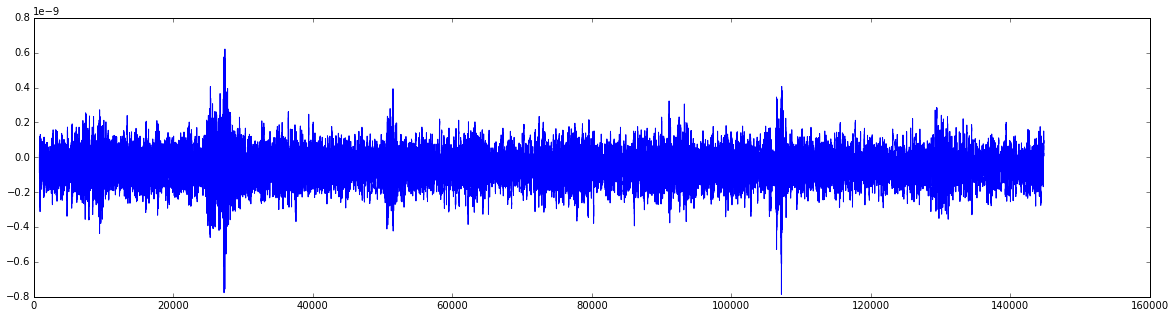

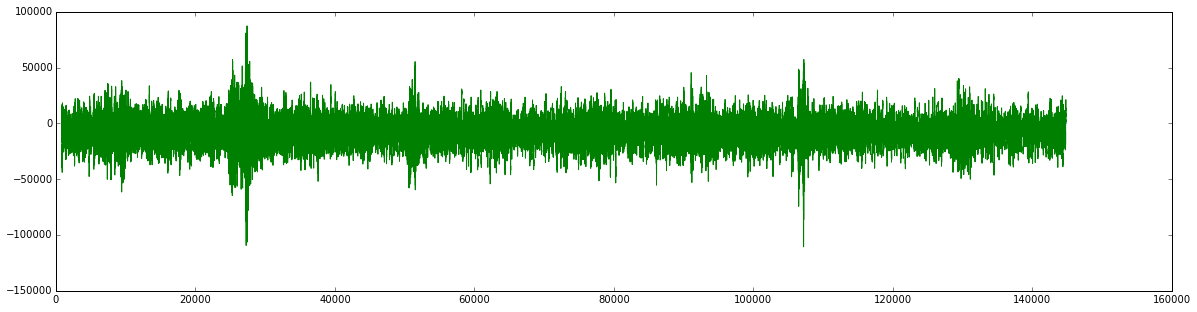

In [29]:
plt.figure(figsize=(20, 5))

plt.plot(vdec_s.data * 67.5675675676 - llnl_s.data)

plt.figure(figsize=(20, 5))
plt.plot(vdec_s.data)
plt.plot(llnl_s.data * 67.5675675676)

# Importing data from IDCX to LLNL/SAC format

In [20]:
import obspy
import os
from obspy.core.trace import Trace, Stats, UTCDateTime
from sigvisa.utils.fileutils import mkdir_p
from sigvisa.signals.io import _read_waveform_from_file

s = Sigvisa()
entries = s.sql("select sta, chan, time, endtime, datatype, samprate, foff, nsamp, dir, dfile from idcx_wfdisc where sta='NV01' and time < 1205020800")
for (sta, chan, time, endtime, datatype, samprate, foff, nsamp, ddir, dfile) in entries:
    
    # load waveform data from file
    wave_fname = os.path.join(ddir, dfile)
    wave = {'sta': sta,
           'chan': chan,
           'dir': ddir,
           'dfile': dfile,
           'samprate': samprate,
           'datatype': datatype,
           'nsamp': nsamp,
           'foff': foff}
    
    wave_data = np.array(_read_waveform_from_file(wave, 0, nsamp, calibrate=False))
    
    # construct filename for SAC file
    base_dir = os.path.join(s.signals_base_dir, "llnl_data")
    base_sac_dir = os.path.join("NV01", "vdec_imported")
    mkdir_p(os.path.join(base_dir, base_sac_dir))
    sac_fname = dfile + ".SAC"
    sac_path = os.path.join(base_dir, base_sac_dir, sac_fname)
    
    # construct obspy/SAC object
    stats = Stats()
    stats.station = sta
    stats.sampling_rate=samprate
    stats.delta=1.0/samprate
    stats.npts = nsamp
    stats.channel = chan
    stats.starttime = UTCDateTime(time)
    
    tr = Trace(data=wave_data, header=stats)
    # write SAC file
    tr.write(sac_path, format='SAC')
    print "wrote", sac_path
    
    # then add entry to llnl wfdisc
    insert_query = "insert into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname, calib) values ('%s', '%s', %f, %f, %f, %f, %d, '%s', '%s', 1.0)" 
    insert_query = insert_query % (sta, chan, time, time + nsamp/float(samprate), samprate, 1.0/samprate, nsamp, base_sac_dir, sac_fname)
    print insert_query
    s.sql(insert_query)
    
s.dbconn.commit()

wrote /home/dmoore/ctbt_data/llnl_data/NV01/vdec_imported/ArchNVAR.1203638400.w.SAC
insert into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname, calib) values ('NV01', 'sz', 1203638400.000000, 1203652800.000000, 40.000000, 0.025000, 576000, 'NV01/vdec_imported', 'ArchNVAR.1203638400.w.SAC', 1.0)
wrote /home/dmoore/ctbt_data/llnl_data/NV01/vdec_imported/ArchNVAR.1203652800.w.SAC
insert into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname, calib) values ('NV01', 'sz', 1203652800.000000, 1203667200.000000, 40.000000, 0.025000, 576000, 'NV01/vdec_imported', 'ArchNVAR.1203652800.w.SAC', 1.0)
wrote /home/dmoore/ctbt_data/llnl_data/NV01/vdec_imported/ArchNVAR.1203667200.w.SAC
insert into llnl_wfdisc (sta, chan, stime, etime, hz, delta, npts, subdir, fname, calib) values ('NV01', 'sz', 1203667200.000000, 1203681600.000000, 40.000000, 0.025000, 576000, 'NV01/vdec_imported', 'ArchNVAR.1203667200.w.SAC', 1.0)
wrote /home/dmoore/ctbt_data/llnl_data/NV01/vd

In [30]:
s.dbconn.commit()

In [31]:
s.dbconn.close()